#  ỨNG DỤNG AI ĐỂ PHÂN LOẠI CÁC GIAI ĐOẠN GIẤC NGỦ TỪ EEG ĐƠN KÊNH
Môn học: Mạng cảm biến

Lớp: D22CQCI01-N

Sinh viên thực hiện:
- Nguyễn Ngọc Hồng Ánh - N22DCCI001
- Phan Ngọc Ngân - N22DCCI026

# 1. Giới thiệu
- Mục tiêu dự án:
  + Ứng dụng các kỹ thuật xử lý tín hiệu và trí tuệ nhân tạo (AI) để phân tích dữ liệu sinh học trong quá trình ngủ.
  + Phân loại giấc ngủ thành các giai đoạn: Wake, N1, N2, N3 và REM, theo tiêu chuẩn y khoa. Hỗ trợ chẩn đoán rối loạn giấc ngủ và nâng cao hiệu quả nghiên cứu trong lĩnh vực y học giấc ngủ.
  + Thiết kế pipeline xử lý đầy đủ gồm: tiền xử lý dữ liệu, trích xuất đặc trưng, huấn luyện mô hình học sâu và đánh giá hiệu suất mô hình.

- Ứng dụng: Theo dõi giấc ngủ, thiết bị y tế đeo được, cải thiện sức khỏe.

- Dataset: Sleep-EDF Expanded dataset từ PhysioNet.

# 2. Tổng quan Dataset

## Nguồn dữ liệu
Dự án sử dụng Sleep-EDF Expanded Dataset do PhysioNet cung cấp. Đây là một tập dữ liệu giấc ngủ chuẩn hóa, được ghi lại từ các đối tượng khỏe mạnh trong nghiên cứu về rối loạn giấc ngủ tại Bệnh viện European Sleep Research Society.

## Cấu trúc dữ liệu:
- PSG file (*.PSG.edf): chứa các tín hiệu sinh lý như EEG, EOG, EMG,... được thu liên tục trong suốt thời gian ngủ. Định dạng EDF (European Data Format).

- Hypnogram file (*.Hypnogram.edf): chứa thông tin giai đoạn ngủ tương ứng với các đoạn thời gian 30 giây. Các nhãn này sẽ được sử dụng làm ground truth.

## Kênh EEG sử dụng
Các bản ghi sử dụng một trong hai kênh EEG chính:

- Fpz-Cz: ở tập SC (Sleep Cassette)

- Pz-Oz: ở tập ST (Sleep Telemetry)

Trong các ứng dụng đơn kênh EEG, ta thường chỉ sử dụng Fpz-Cz hoặc Pz-Oz. Ở dự án này sẽ sử dụng Fpz-Cz.

## Các giai đoạn ngủ (Sleep Stages)
- W: Wake (Tỉnh)
- N1: Stage 1 (Ngủ nông)
- N2: Stage 2 (Ngủ sâu vừa)
- N3: Stage 3 hoặc 4 (Ngủ sâu (N3 và N4 thường gộp))
- R: REM (Ngủ mơ)
- ?: Không xác định (Không dùng để huấn luyện)

# 3. Importing thư viện và khởi tạo biến

In [ ]:
%matplotlib inline

import glob
import math
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import edfreader
import models
import mne
import pyeeg
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_array_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import FunctionTransformer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
# from tensorflow.keras import optimizers, losses
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation, SpatialDropout1D, GlobalMaxPool1D
# from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
# from tensorflow.keras.layers import concatenate
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import joblib
# from sklearn.preprocessing import StandardScaler
# from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers import CRF

from scipy.signal import butter, lfilter

WINDOW_SIZE = 100
Fs = 100

VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

# 4. Data Preprocessing

## Tùy chỉnh hàm fetch_data để nhập dữ liệu của tất cả các đối tượng (subjects)

In [ ]:
# localized fetch_data function by using mne library
# https://github.com/mne-tools/mne-python/blob/maint/0.20/mne/datasets/sleep_physionet/age.py#L18-L111
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

## Đọc dữ liệu input

In [ ]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

100%|#####################################| 48.3M/48.3M [00:00<00:00, 24.0GB/s]
100%|#####################################| 4.62k/4.62k [00:00<00:00, 2.31MB/s]
100%|#####################################| 51.6M/51.6M [00:00<00:00, 23.9GB/s]
100%|#############################################| 4.58k/4.58k [00:00<?, ?B/s]
100%|#############################################| 51.1M/51.1M [00:00<?, ?B/s]
100%|######################################| 3.90k/3.90k [00:00<00:00, 419kB/s]
100%|#############################################| 52.0M/52.0M [00:00<?, ?B/s]
100%|#####################################| 5.08k/5.08k [00:00<00:00, 2.01MB/s]
100%|#####################################| 51.1M/51.1M [00:00<00:00, 5.97GB/s]
100%|#####################################| 4.80k/4.80k [00:00<00:00, 1.44MB/s]
100%|#####################################| 50.3M/50.3M [00:00<00:00, 52.2GB/s]
100%|#####################################| 5.29k/5.29k [00:00<00:00, 5.28MB/s]
100%|###################################

## Lấy mẫu dữ liệu và lưu kết quả dưới định dạng NPZ

In [ ]:
print(item)
print(type(item), type(item[0]))


[('d:\\Study\\DH\\MangCamBien\\final-sleep-stage-classification\\thamkhao\\Sleep-Stage-Classification-master\\Sleep-Stage-Classification-master\\physionet-sleep-data\\SC4001E0-PSG.edf', True), ('d:\\Study\\DH\\MangCamBien\\final-sleep-stage-classification\\thamkhao\\Sleep-Stage-Classification-master\\Sleep-Stage-Classification-master\\physionet-sleep-data\\SC4001EC-Hypnogram.edf', True)]
<class 'list'> <class 'tuple'>


In [ ]:
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0][0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0][0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame()[ch_labels]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))

        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0][0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = edfreader.BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1][0], 'r')
        annot_raw_read = edfreader.BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []

        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x,
            "y": y,
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

Importing data into dataframes:


  0%|          | 0/150 [00:00<?, ?it/s]

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sl

## Hiển thị dữ liệu của 20 đối tượng đầu tiên và lưu kết quả vào file PDF

  0%|          | 0/20 [00:00<?, ?it/s]

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.


<Figure size 640x480 with 0 Axes>

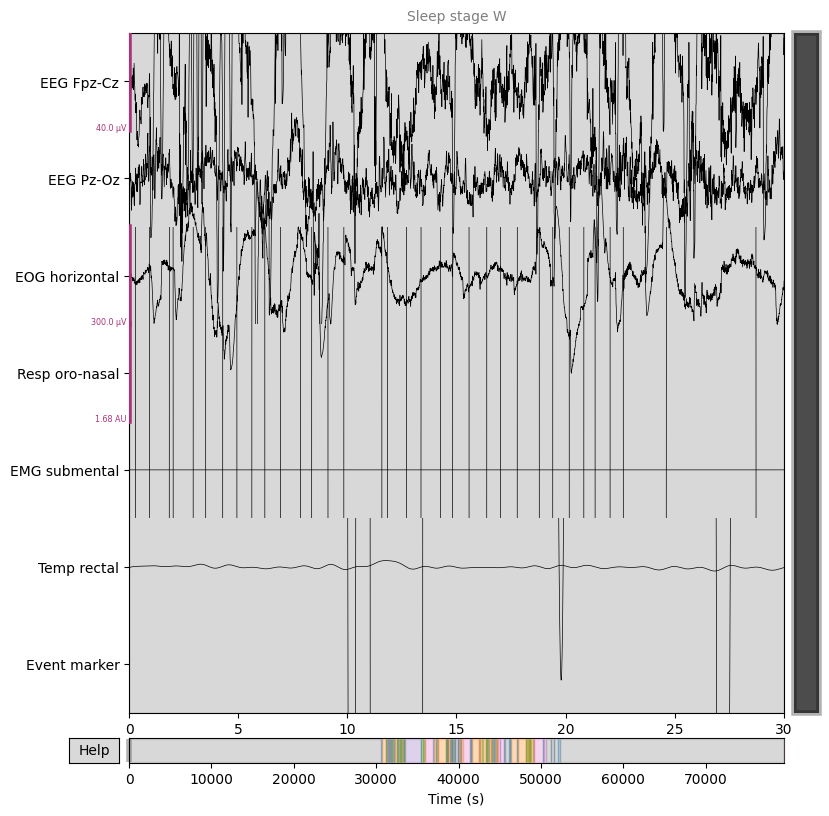

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


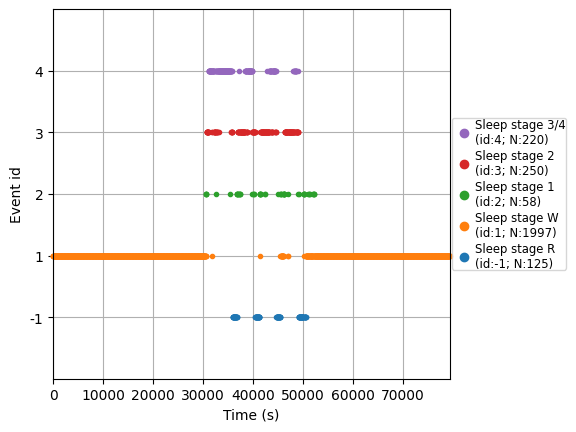

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

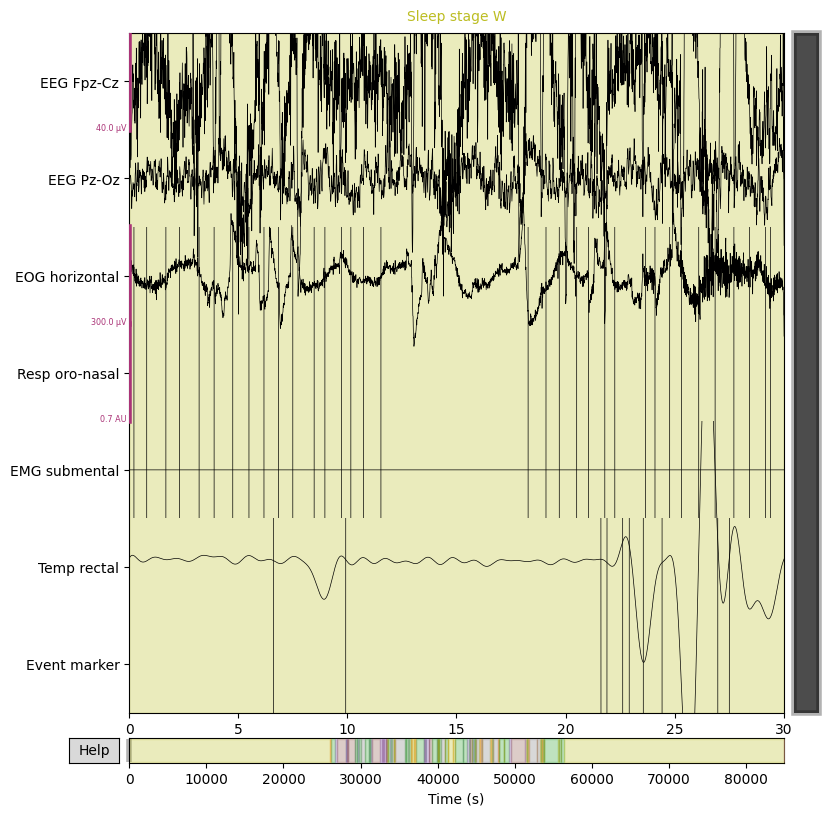

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


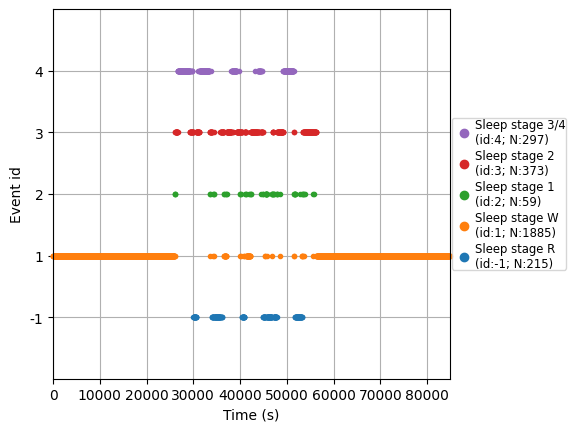

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

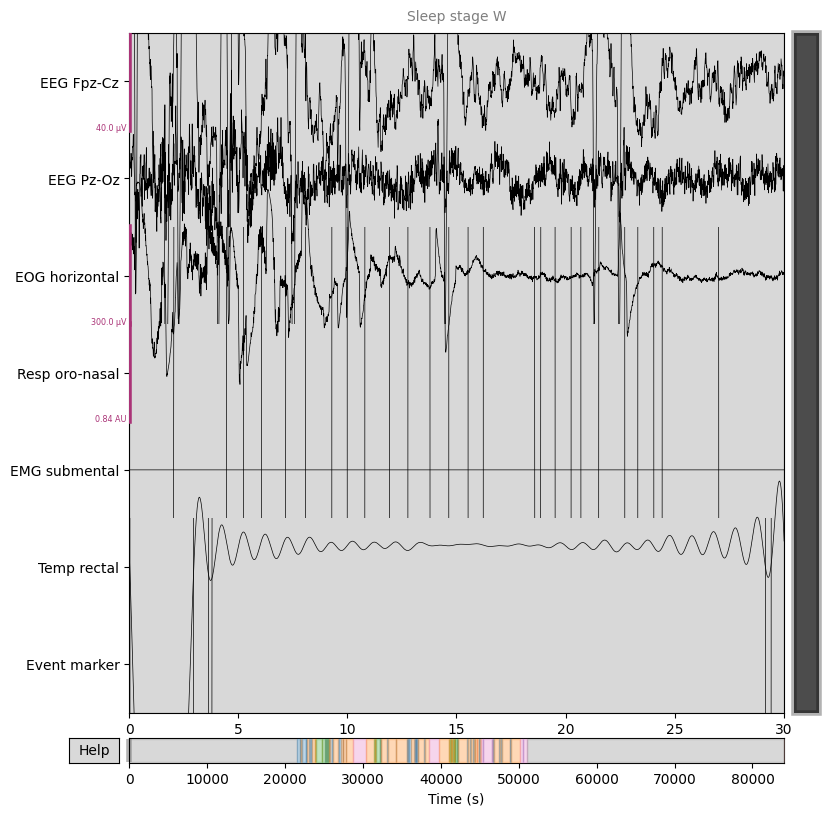

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


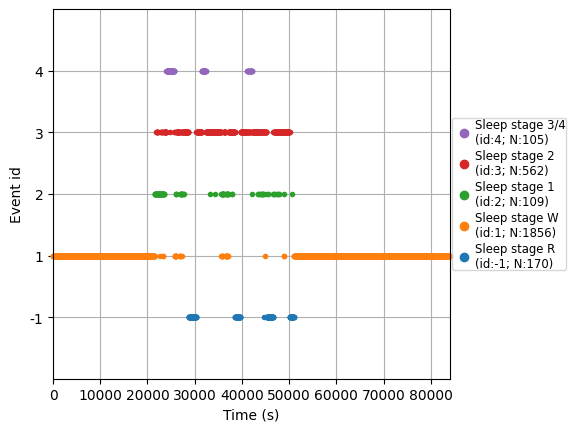

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

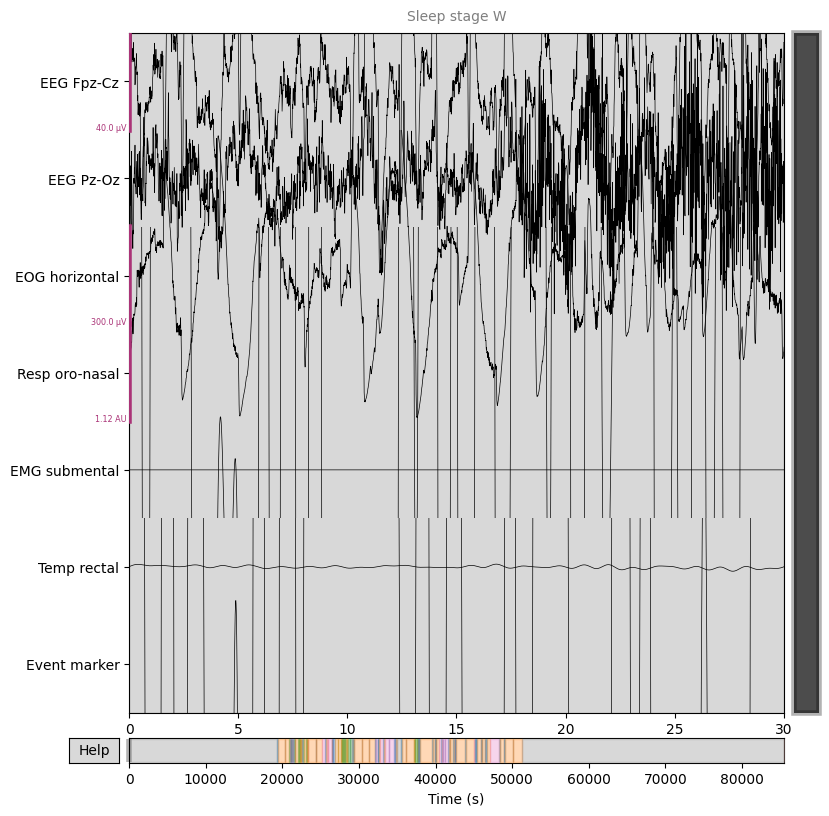

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


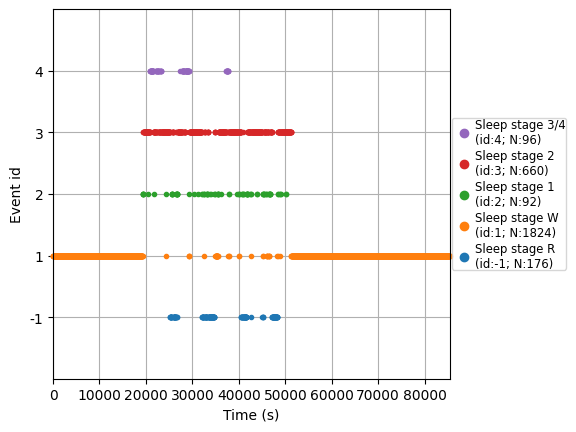

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

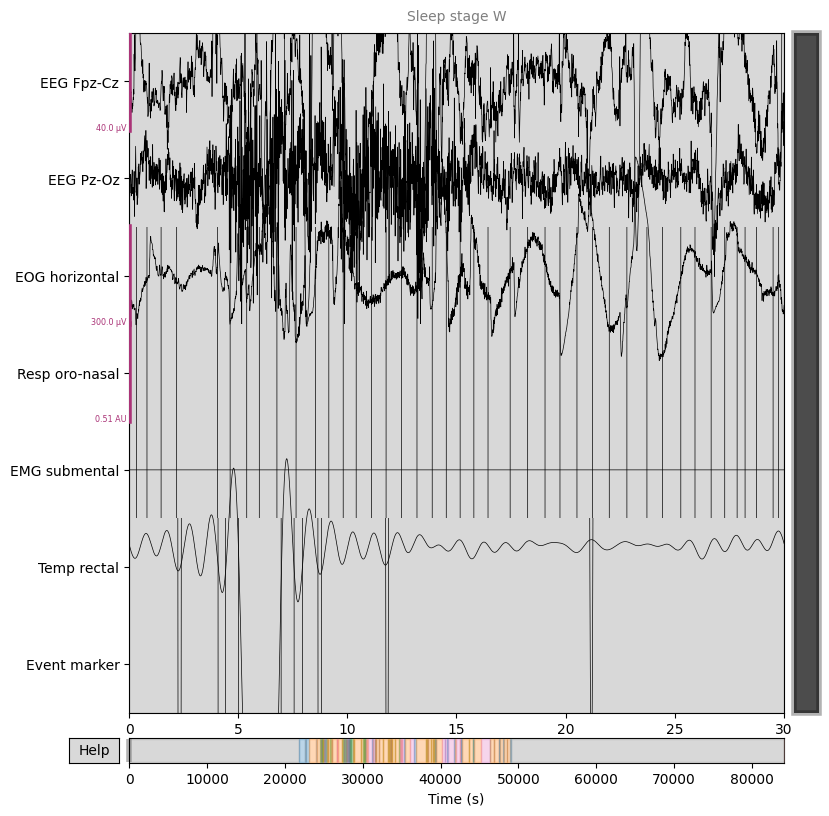

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


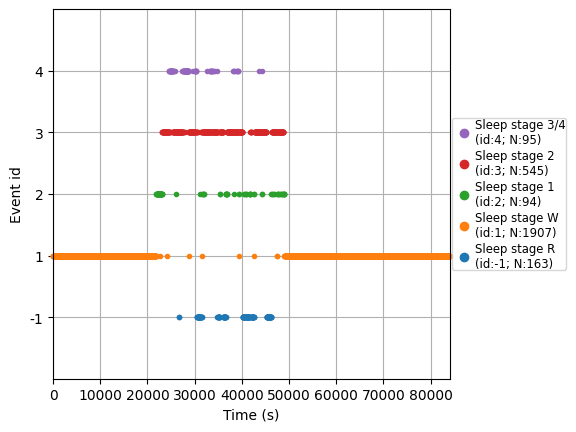

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

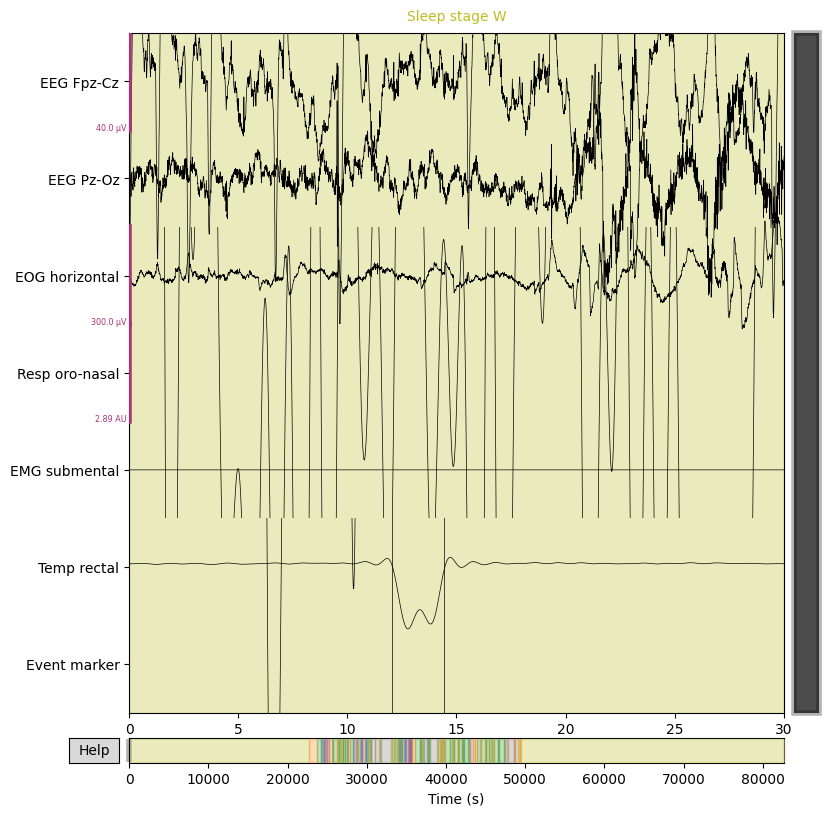

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


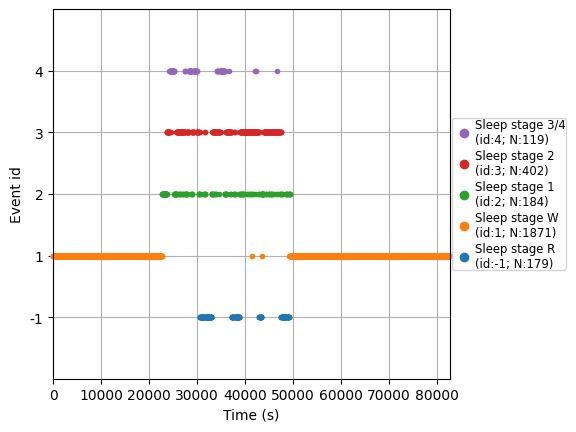

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

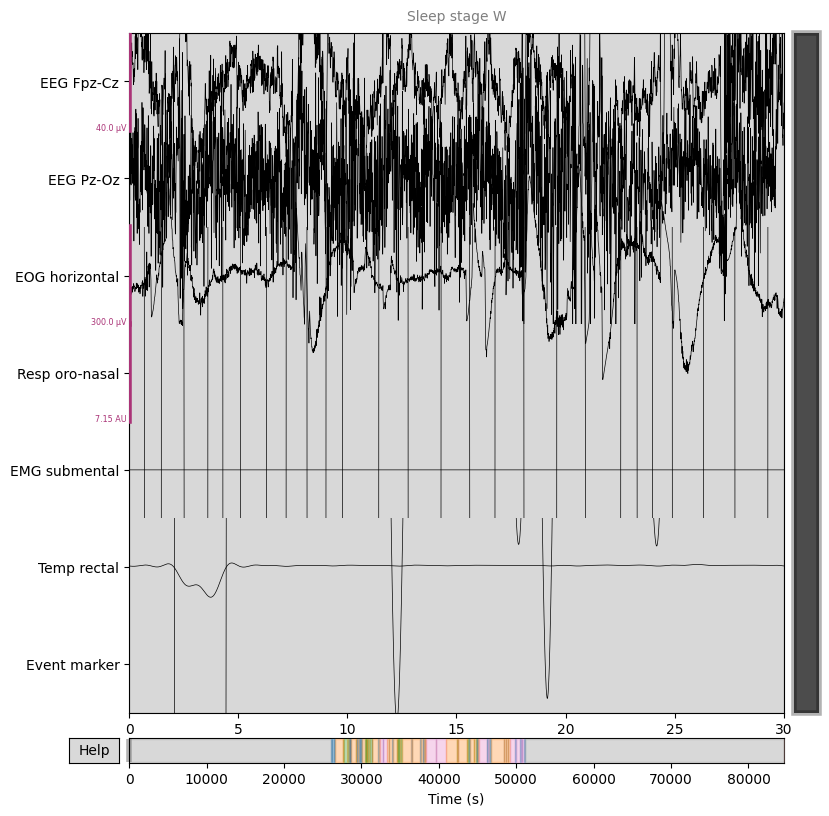

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


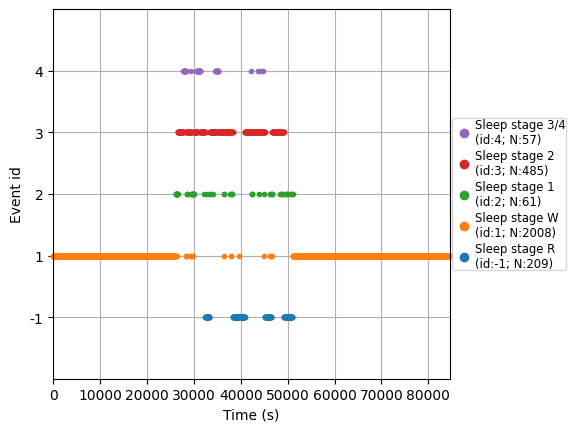

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

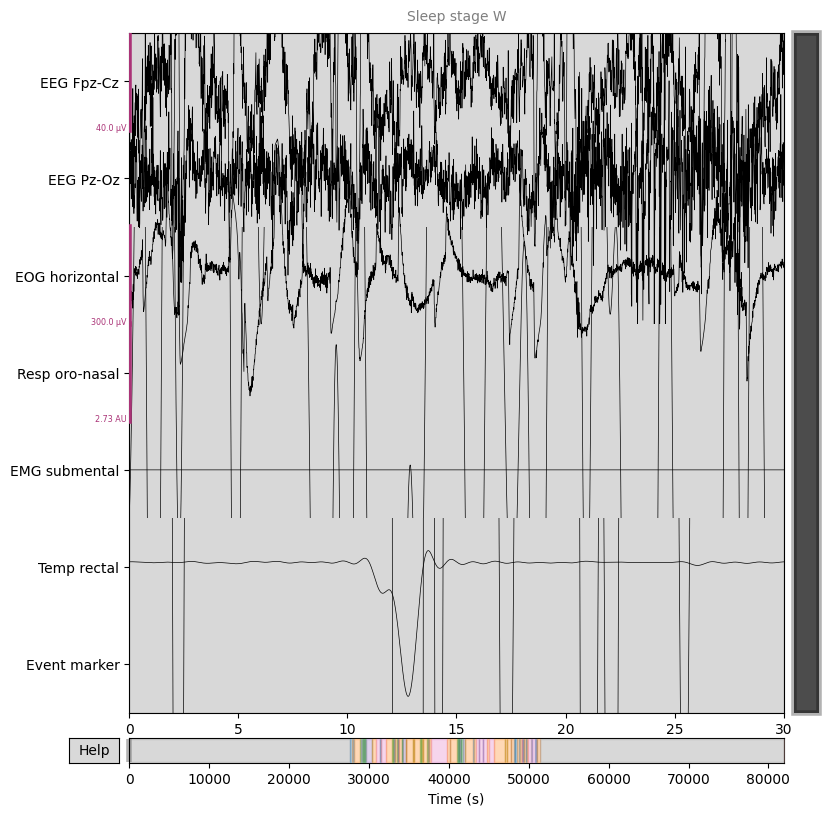

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


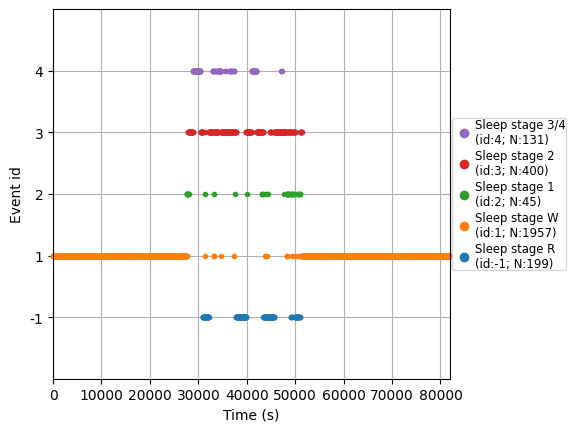

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

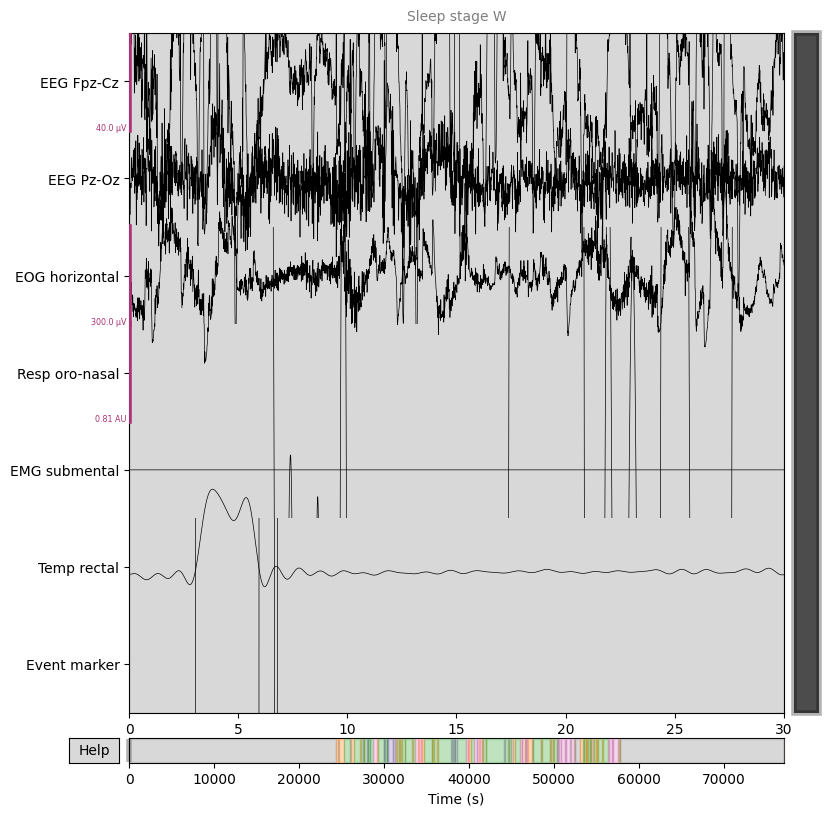

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


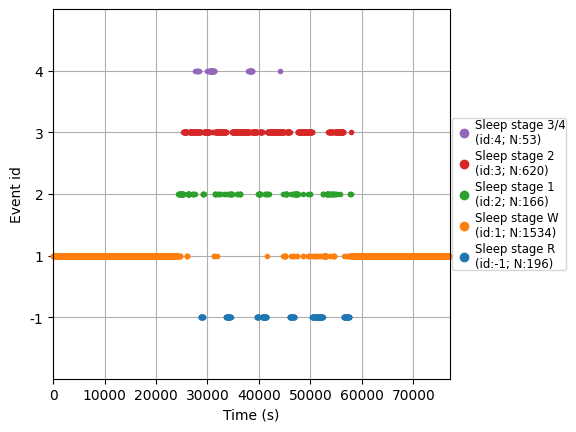

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

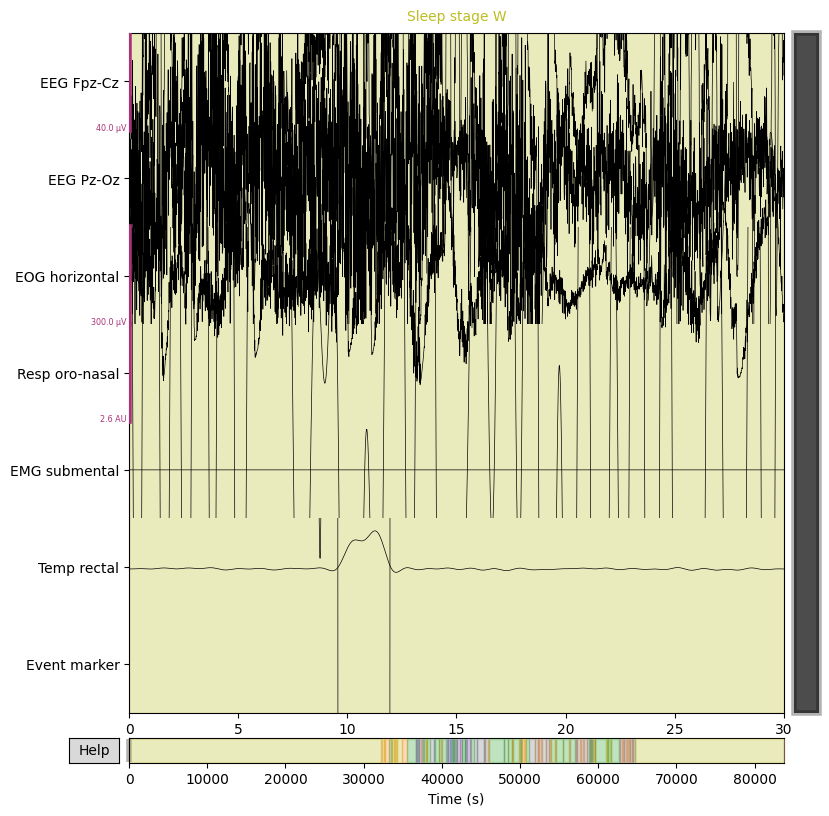

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


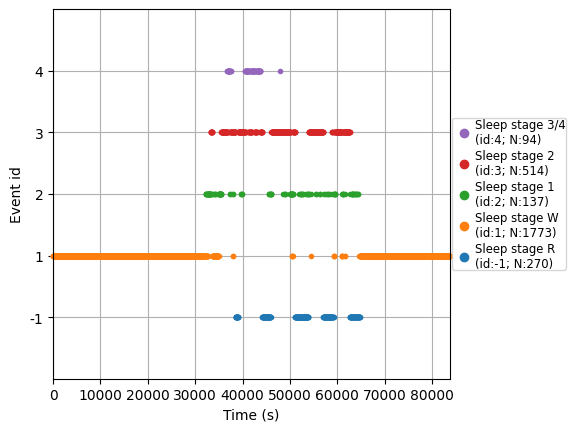

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

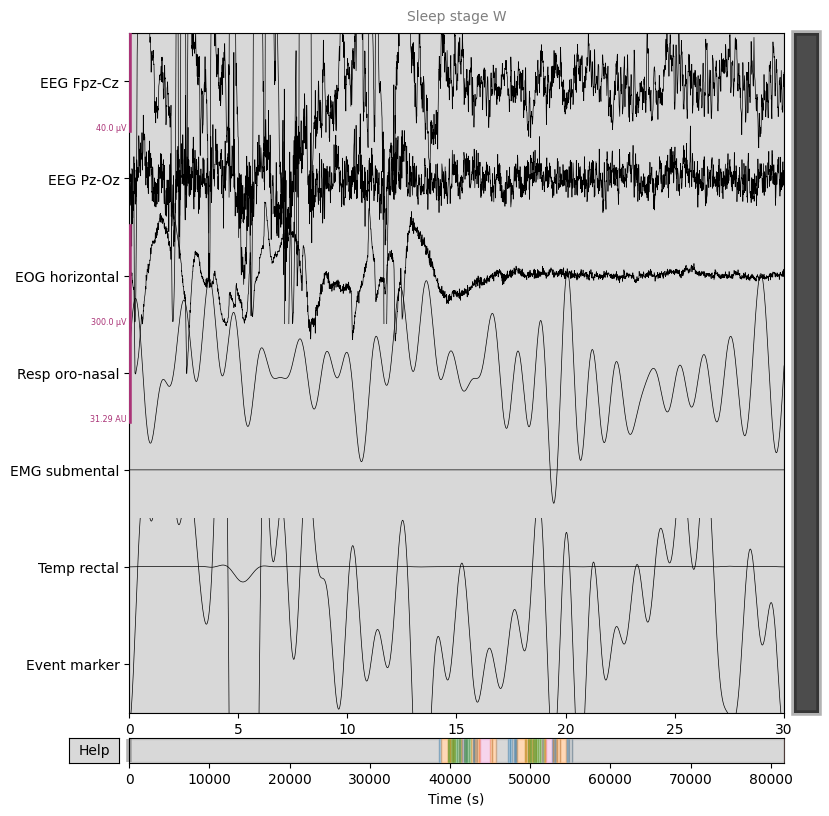

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


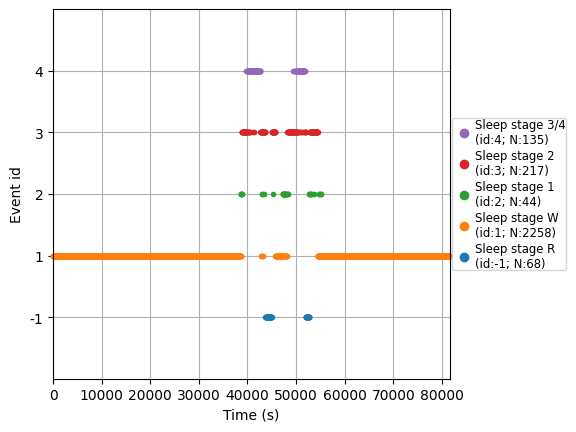

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

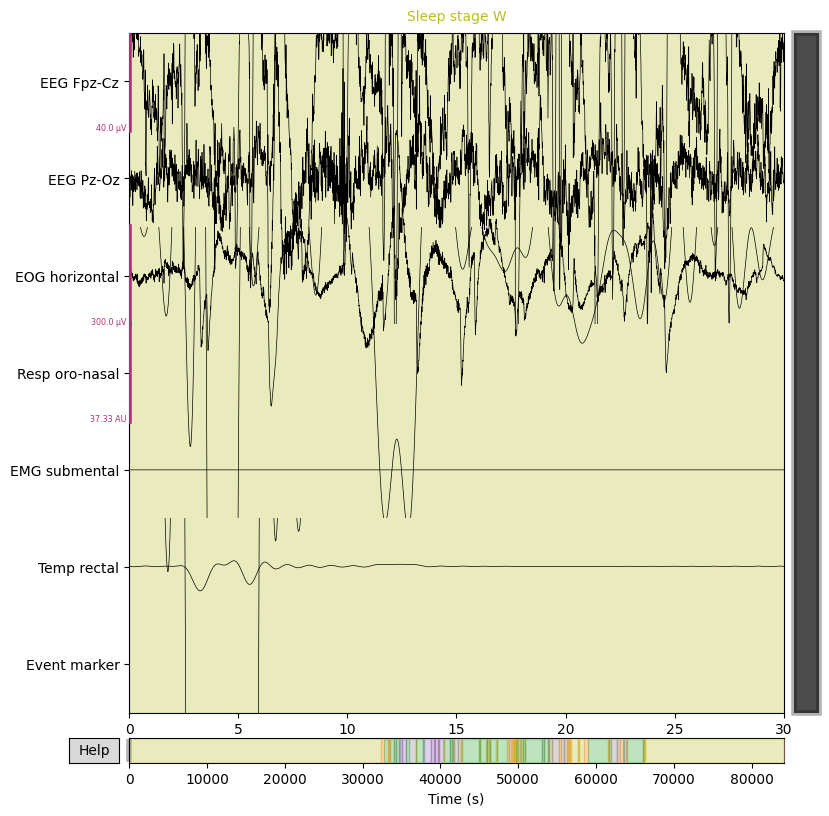

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


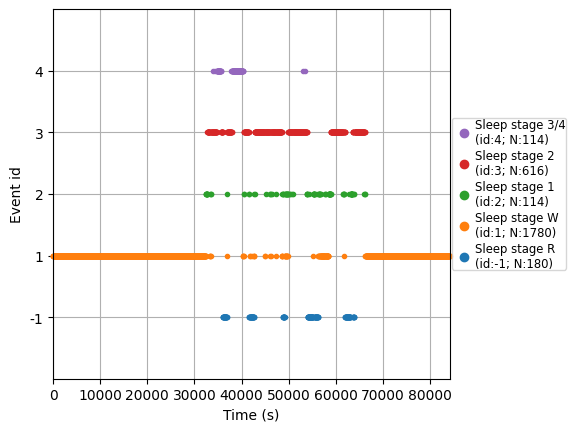

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

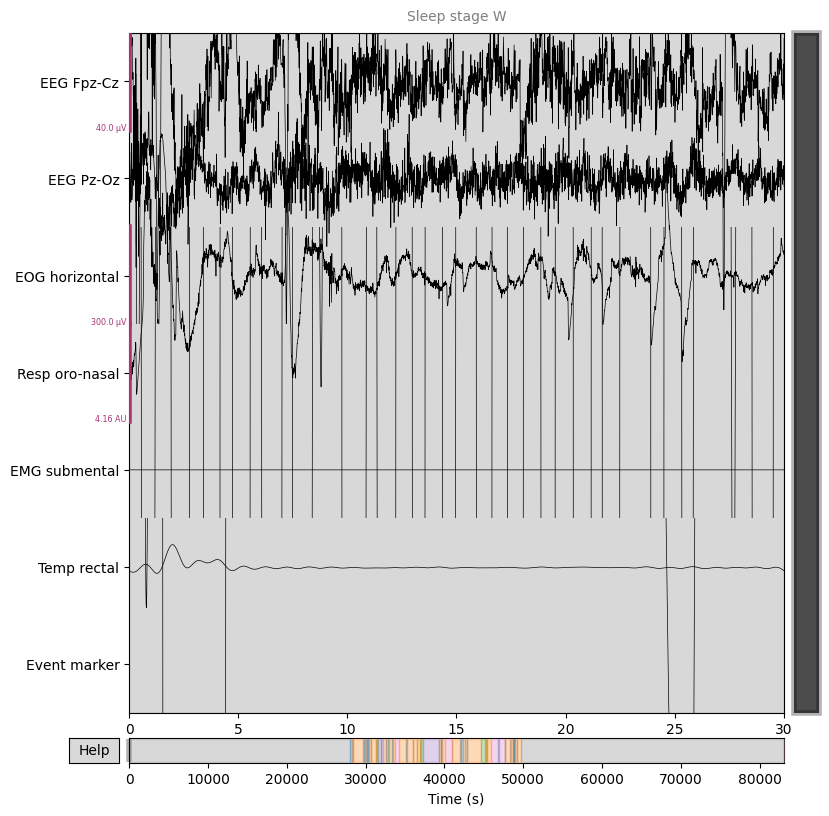

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


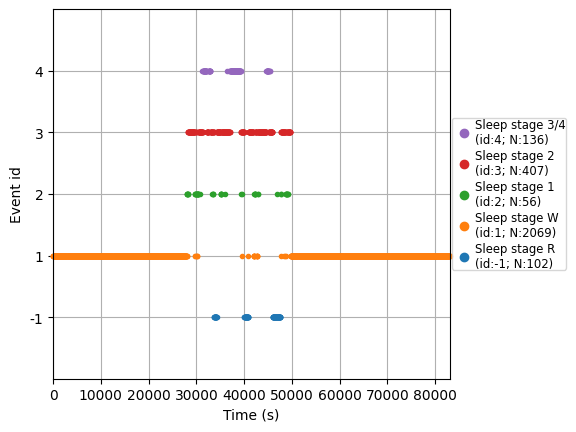

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

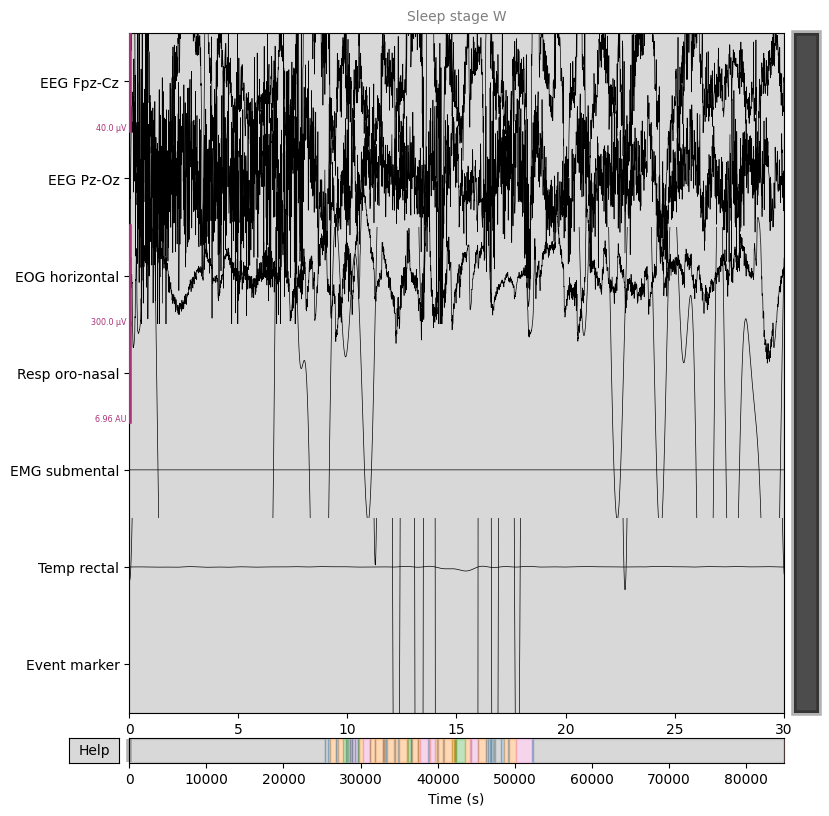

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


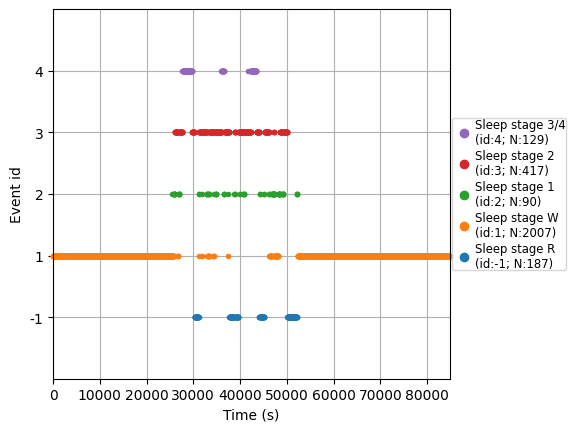

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

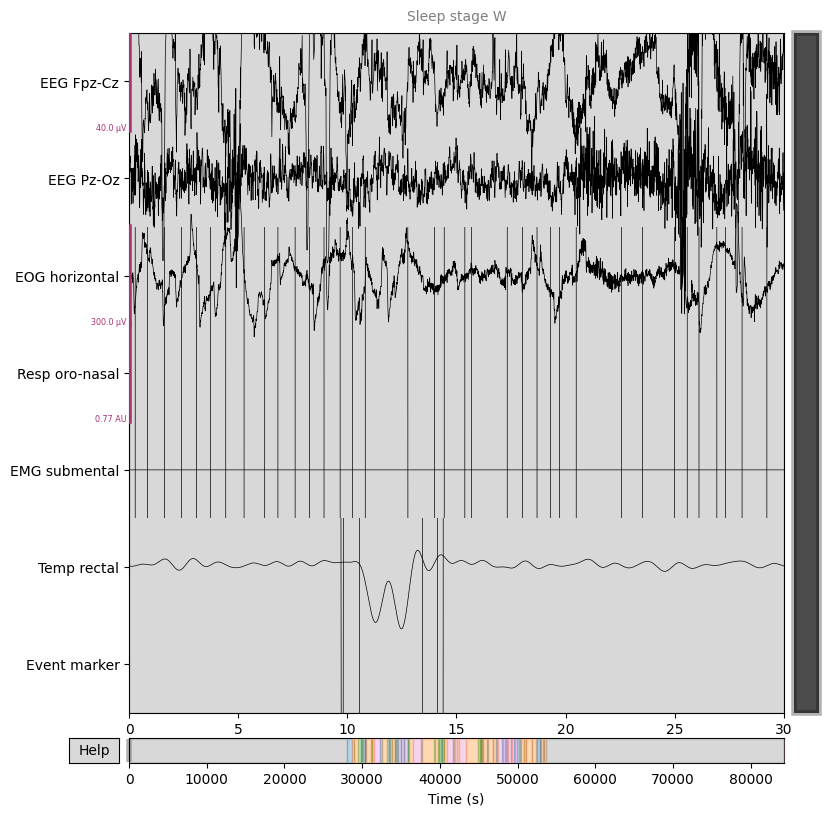

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


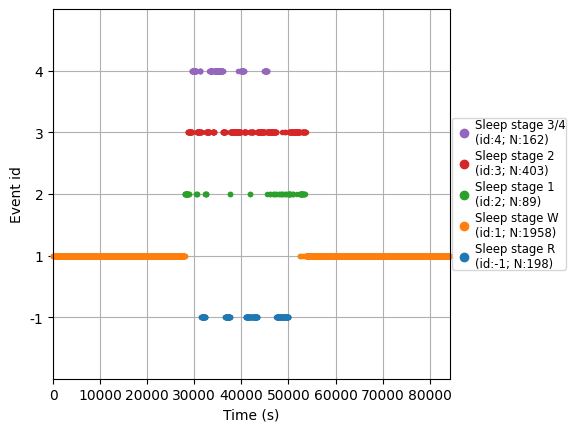

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

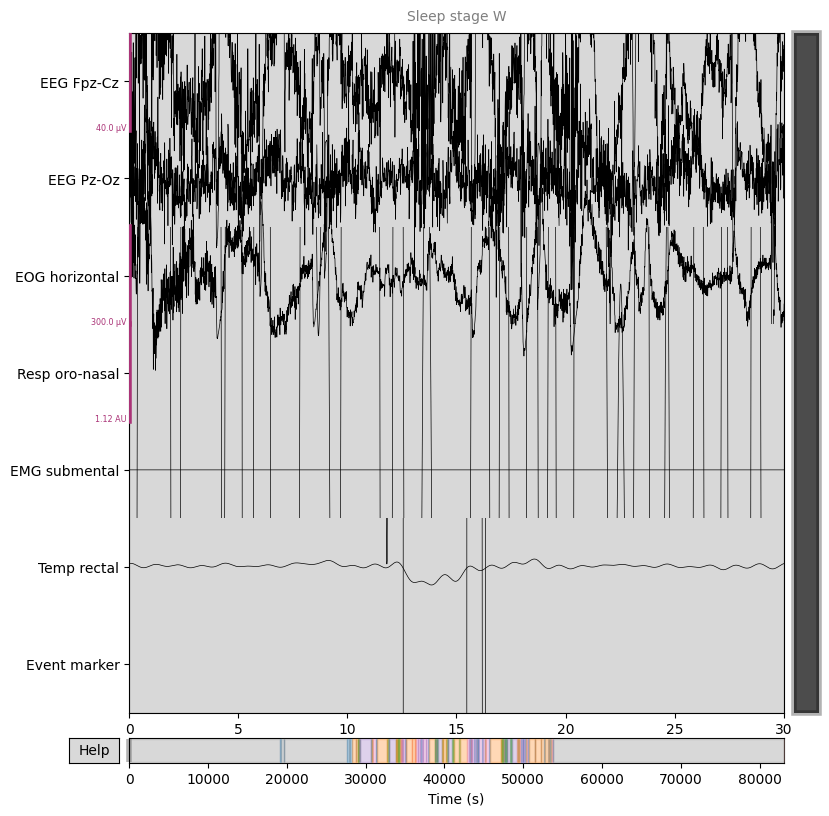

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


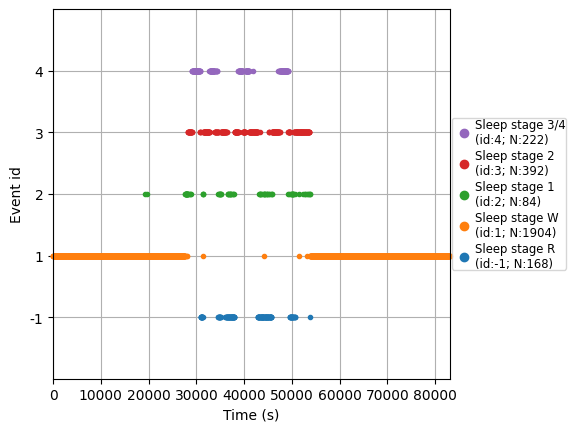

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

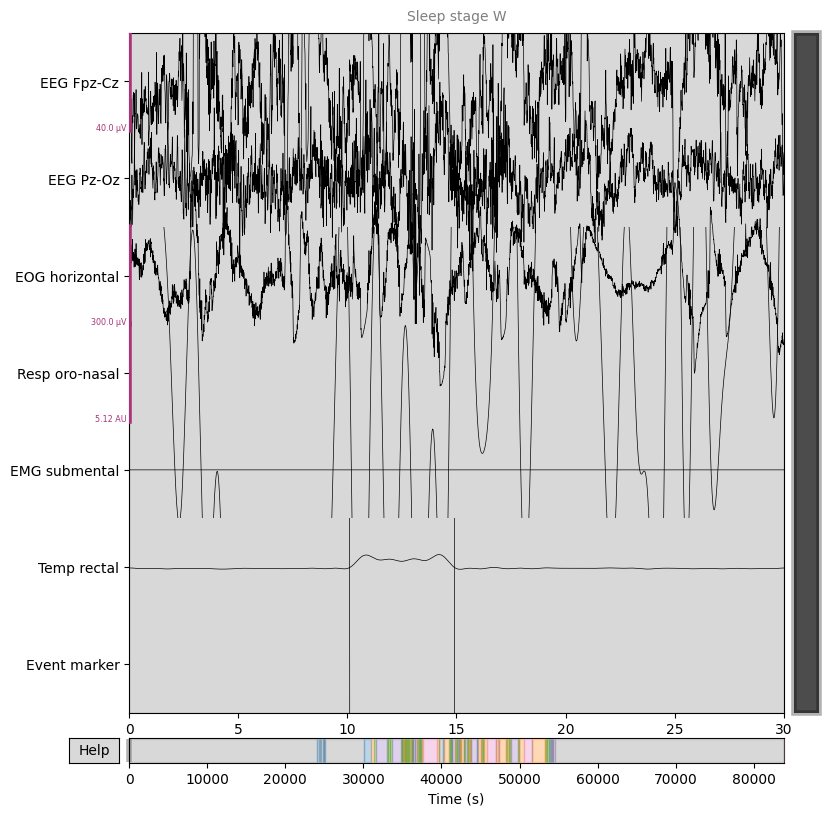

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


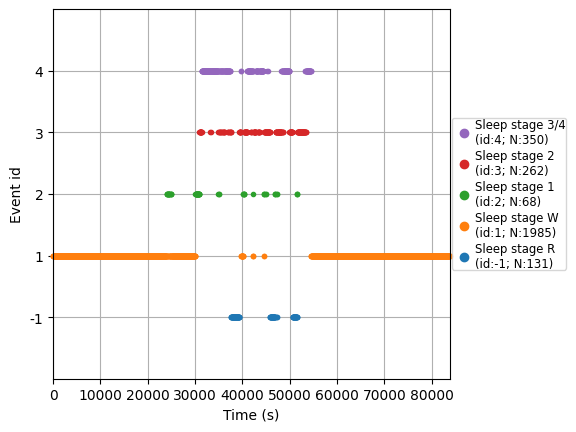

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

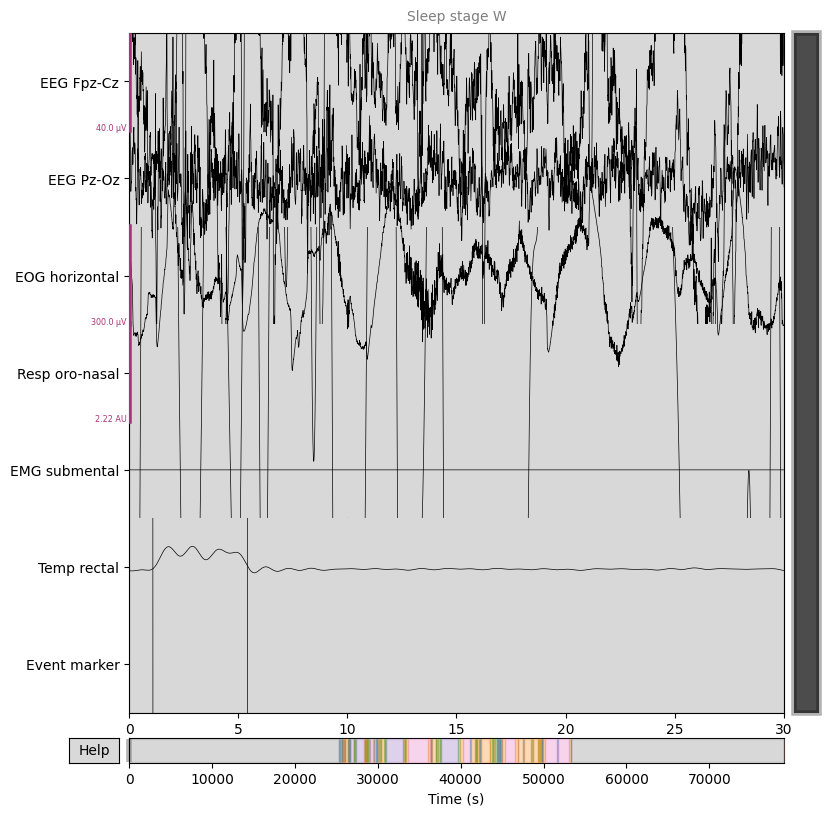

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


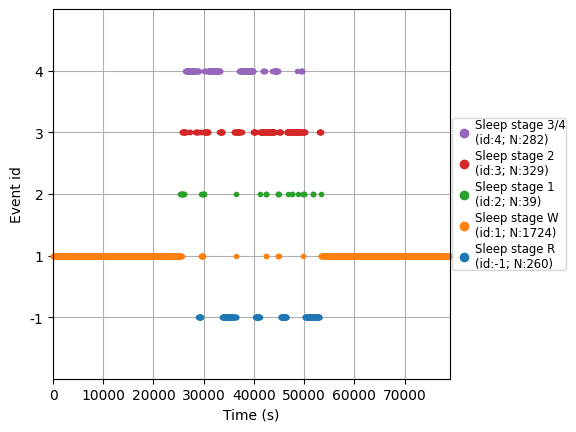

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

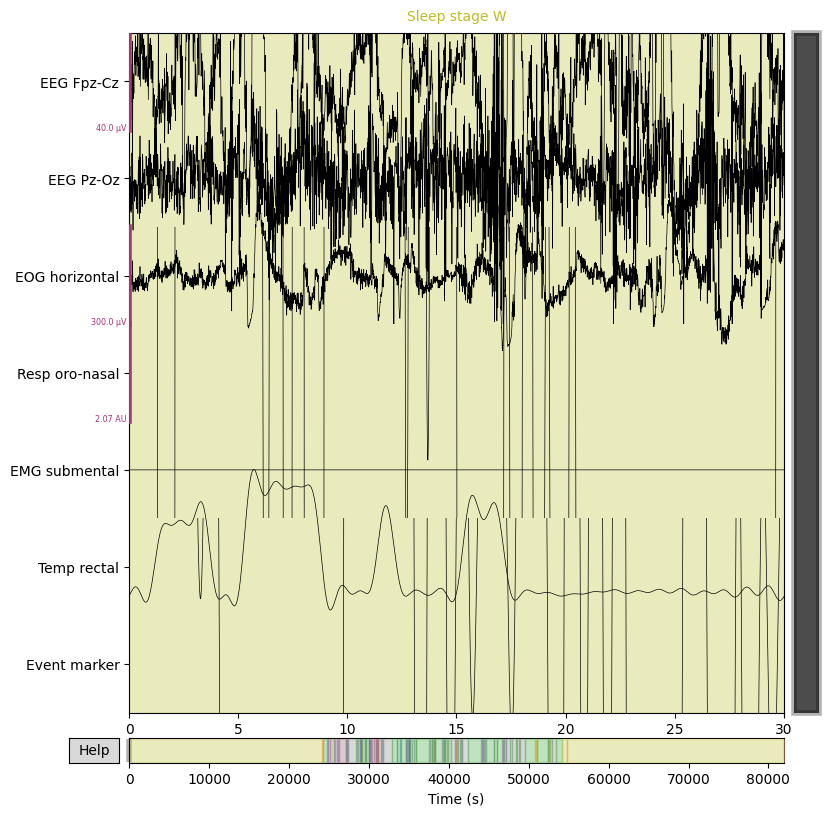

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


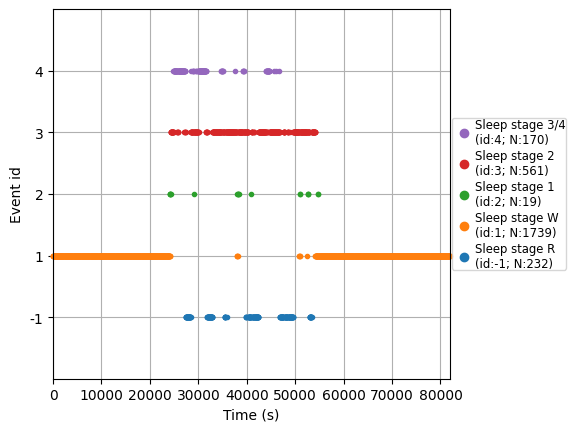

Extracting EDF parameters from d:\Study\DH\MangCamBien\final-sleep-stage-classification\thamkhao\Sleep-Stage-Classification-master\Sleep-Stage-Classification-master\physionet-sleep-data\SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 640x480 with 0 Axes>

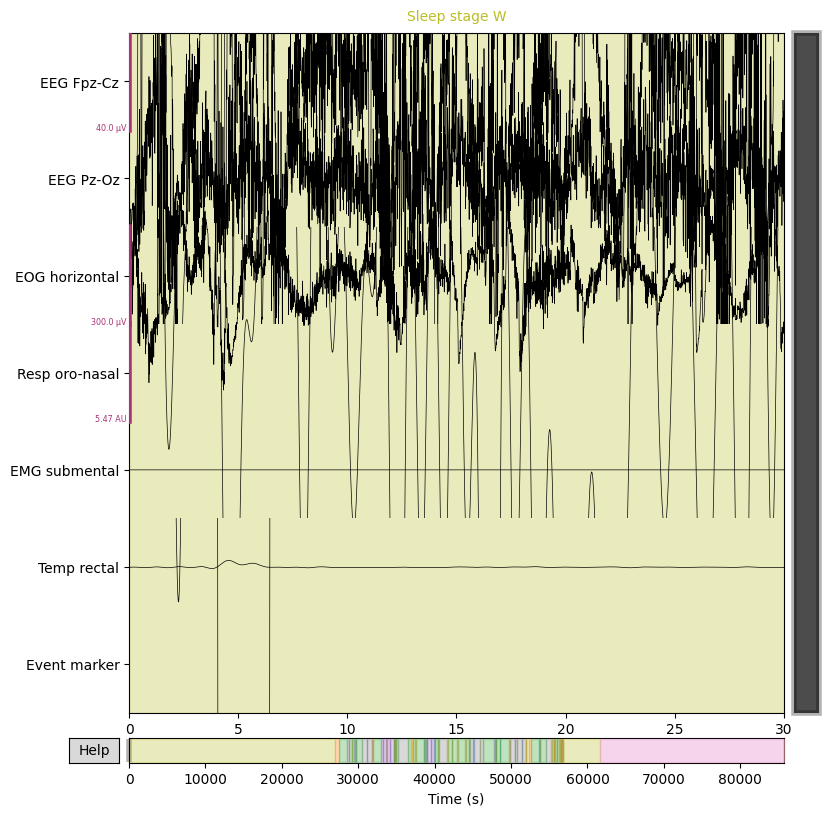

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


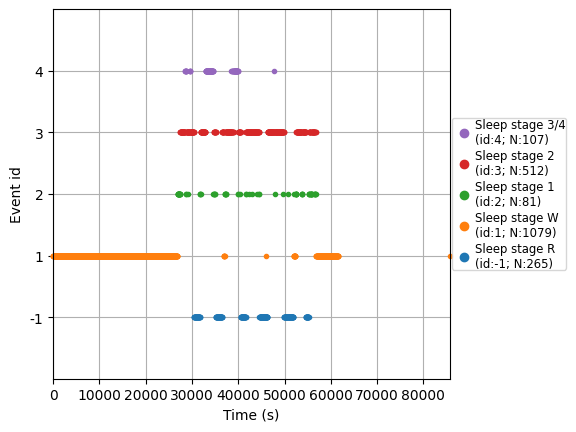

In [ ]:
# plotting some of the subjects' raw signals and thier sleep stage
pdf_report = PdfPages('Sleep_Plots.pdf')
for item in tqdm(subject_files[:20]):  # selecting the first 20 subjects
    raw_train = mne.io.read_raw_edf(item[0][0], verbose=VBS)
    annot_train = mne.read_annotations(item[1][0])  # reading the hypnogram files

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)
    figure = plt.figure()
    figure.suptitle("Subject: " + str(item[0][-13:-11]) + ", Night: " + str(item[0][-11:-10]))
    pdf_report.savefig(figure, bbox_inches='tight')
    pdf_report.savefig(raw_train.plot(duration=30), bbox_inches='tight')

    annotation_desc_2_event_id = {'Sleep stage R': -1,
                                  'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4
    }

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage R'  : -1,
                'Sleep stage W'  : 1,
                'Sleep stage 1'  : 2,
                'Sleep stage 2'  : 3,
                'Sleep stage 3/4': 4
    }
    # plot events and saving them in PDF report
    pdf_report.savefig(mne.viz.plot_events(events_train, event_id=event_id,
                        sfreq=raw_train.info['sfreq']), bbox_inches='tight')
pdf_report.close()

# 4. Trích xuất đặc trưng

In [ ]:
from hurst import compute_Hc
Fs= 100
band_list = [0.5,4,7,12,30]
PSD = []  # Power Spectral Density
PFD = []  # Petrosian Fractal Dimension
hjorths = []  # Hjorth Parameters
hursts = []  # Hurst Exponent
DFA = []  # Detrended Fluctuation Analysis
for item in tqdm(subject_files[:5]):
    raw_test = mne.io.read_raw_edf(item[0][0], verbose=False)
    signals_list = raw_test[0][0][0]
    first_order = np.diff(signals_list).tolist()
    PSD.append(pyeeg.bin_power(signals_list, band_list, Fs))
    PFD.append(pyeeg.pfd(signals_list, first_order))
    hjorths.append(pyeeg.hjorth(signals_list, first_order))
    hursts.append(compute_Hc(signals_list, kind='change', min_window=100))
    DFA.append(pyeeg.dfa(signals_list))

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
if VBS:
    print("Petrosian Fractal Dimension (PFD): ", PFD)
    print("Hjorth mobility and complexity: ", hjorths)
    print("Detrended Fluctuation Analysis (DFA): ", DFA)
    print("Hurst Exponent (Hurst): ", hursts)

Petrosian Fractal Dimension (PFD):  [0.5260813226365344, 0.524797335166937, 0.5296215973392818, 0.5294222017464901, 0.5267916487609091]
Hjorth mobility and complexity:  [(0.0001242622534516733, 13143.036280788516), (0.00018132418018598445, 9335.362942673955), (5.907335927673209e-05, 20875.12130562849), (6.000383534000729e-05, 21344.445095750732), (9.11423315792555e-05, 17072.109438632604)]
Detrended Fluctuation Analysis (DFA):  [0.13913468824876388, 0.23940635037879304, 0.19817581210315935, 0.20098505597555377, 0.19821142314924287]
Hurst Exponent (Hurst):  [(0.5835558023705112, 1.9675214804449506, [[100, 177, 316, 562, 1000, 1778, 3162, 5623, 10000, 17782, 31622, 56234, 100000, 177827, 316227, 562341, 1000000, 1778279, 3162277, 5623413, 7950000], [66.155289324895, 78.03278176625084, 92.8269827023827, 109.1797641429729, 127.685467256491, 148.35310840475495, 170.87570151326753, 199.11435939199475, 236.607566194322, 295.30064301639317, 401.0119507395091, 567.6520016324292, 867.84784128720

## Đọc các file NPZ cho tập huấn luyện (training dataset)

In [ ]:
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files

npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Frequency of the labels in our dataset')

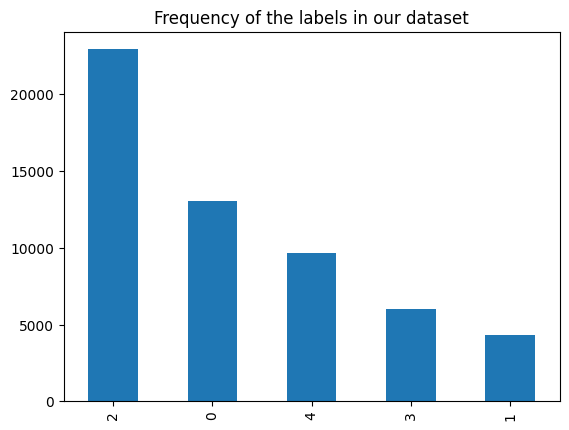

In [ ]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [ ]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

# X_train = np.squeeze(X_train)
# X_test = np.squeeze(X_test)
# X_val = np.squeeze(X_val)

Shape of the input data: (55989, 3000, 1)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (45351, 3000, 1)
test_dataset: (5599, 3000, 1)



# 5. Model Architecture

## 5.1 Model CNN-LSTM

In [ ]:
def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a

def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])
# pp_X_test = np.expand_dims(pp_X_test, axis=2)
# pp_X_train = np.expand_dims(pp_X_train, axis=2)
# pp_X_val = np.expand_dims(pp_X_val, axis=2)
if VBS:
    print(pp_X_val.shape)
    print(pp_X_train.shape)

(5039, 3000, 1)
(45351, 3000, 1)


In [ ]:
checkpoint = ModelCheckpoint("model3headslstm.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
    redonplat,
    csv_logger,
]

In [ ]:
def model_b(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
    """Recurrent_Deep_Neural_Networks_for_Real-Time_Sleep
    """
    inputLayer = Input(shape=(3000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.shape
    convFine = Flatten(name='fFlat1')(convFine)

    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.shape
    convCoarse = Flatten(name='cFlat1')(convCoarse)

    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)

    outLayer = Reshape((1, outLayer.shape[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)

    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    if verbose:
        model.summary()
    return model

In [ ]:
model_cnn = model_b(verbose=VBS)
hist_19 = model_cnn.fit(
    pp_X_train, y_train_, batch_size=batch_size, epochs=30, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inLayer             │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fConv1 (Conv1D)     │ (None, 500, 64)   │      3,264 │ inLayer[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cConv1 (Conv1D)     │ (None, 60, 32)    │     12,832 │ inLayer[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fMaxP1              │ (None, 62, 64)    │          0 │ fConv1[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cMaxP1              │ (None, 15, 32)    │          0 │ cConv1[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fDrop1 (Dropout)    │ (None, 62, 64)    │          0 │ fMaxP1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cDrop1 (Dropout)    │ (None, 15, 32)    │          0 │ cMaxP1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fConv2 (Conv1D)     │ (None, 62, 128)   │     65,664 │ fDrop1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cConv2 (Conv1D)     │ (None, 15, 128)   │     24,704 │ cDrop1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fConv3 (Conv1D)     │ (None, 62, 128)   │    131,200 │ fConv2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cConv3 (Conv1D)     │ (None, 15, 128)   │     98,432 │ cConv2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fConv4 (Conv1D)     │ (None, 62, 128)   │    131,200 │ fConv3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cConv4 (Conv1D)     │ (None, 15, 128)   │     98,432 │ cConv3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fMaxP2              │ (None, 15, 128)   │          0 │ fConv4[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cMaxP2              │ (None, 7, 128)    │          0 │ cConv4[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fFlat1 (Flatten)    │ (None, 1920)      │          0 │ fMaxP2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cFlat1 (Flatten)    │ (None, 896)       │          0 │ cMaxP2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_1             │ (None, 2816)      │          0 │ fFlat1[0][0],     │
│ (Concatenate)       │                   │            │ cFlat1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mDrop1 (Dropout)    │ (None, 2816)      │          0 │ merge_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape1 (Reshape)  │ (None, 1, 2816)   │          0 │ mDrop1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1, 64)     │    737,536 │ reshape1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     33,024 │ lstm_2[0][0]    

 Total params: 1,336,613 (5.10 MB)

 Trainable params: 1,336,613 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - acc: 0.4521 - loss: 1.3450
Epoch 1: val_loss improved from -inf to 0.71005, saving model to model_cps.weights.h5
709/709 ━━━━━━━━━━━━━━━━━━━━ 76s 94ms/step - acc: 0.4522 - loss: 1.3447 - val_acc: 0.7452 - val_loss: 0.7101 - learning_rate: 1.0000e-04
Epoch 2/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - acc: 0.7493 - loss: 0.6773
Epoch 2: val_loss did not improve from 0.71005
709/709 ━━━━━━━━━━━━━━━━━━━━ 83s 116ms/step - acc: 0.7493 - loss: 0.6773 - val_acc: 0.7869 - val_loss: 0.5641 - learning_rate: 1.0000e-04
Epoch 3/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - acc: 0.7771 - loss: 0.5897
Epoch 3: val_loss did not improve from 0.71005
709/709 ━━━━━━━━━━━━━━━━━━━━ 133s 104ms/step - acc: 0.7771 - loss: 0.5897 - val_acc: 0.7815 - val_loss: 0.5735 - learning_rate: 1.0000e-04
Epoch 4/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - acc: 0.7904 - loss: 0.5546
Epoch 4: val_loss did not improve from 0.71005
709/709 ━━━━━━━━━━━━━━━━━━━━

## 5.2 Model CNN3Head

In [ ]:
def modelcnn3head(n_classes=5, verbose=False):
    n_timesteps = 3000
    n_features = 1
    n_outputs = n_classes
    # head 1
    inputs1 = Input(shape=(n_timesteps, n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPool1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps, n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPool1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps, n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPool1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpertation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    if verbose:
        model.summary()
    return model

In [ ]:
model_cnn3heads = modelcnn3head(verbose=VBS)
X_train_multi = [pp_X_train, pp_X_train, pp_X_train]
X_val_multi = [pp_X_val, pp_X_val, pp_X_val]

hist_20 = model_cnn3heads.fit(
    X_train_multi, y_train_, batch_size=batch_size, epochs=30, validation_data=(X_val_multi, y_val_), callbacks=callbacks_list, verbose=VBS
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 2998, 64)  │        256 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 2996, 64)  │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 2990, 64)  │        768 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 2998, 64)  │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 2996, 64)  │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 2990, 64)  │          0 │ conv1d_20[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 1499, 64)  │          0 │ dropout_18[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 1498, 64)  │          0 │ dropout_19[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 1495, 64)  │          0 │ dropout_20[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 95936)     │          0 │ max_pooling1d_18… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 95872)     │          0 │ max_pooling1d_19… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 95680)     │          0 │ max_pooling1d_20… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 287488)    │          0 │ flatten_18[0][0], │
│ (Concatenate)       │                   │            │ flatten_19[0][0], │
│                     │                   │            │ flatten_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100)       │ 28,748,900 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 5)         │        505 │ dense_12[0][0]  

 Total params: 28,750,813 (109.68 MB)

 Trainable params: 28,750,813 (109.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - categorical_accuracy: 0.4861 - loss: 1.3304
Epoch 1: val_loss improved from -inf to 0.77467, saving model to model3heads.weights.h5
709/709 ━━━━━━━━━━━━━━━━━━━━ 457s 642ms/step - categorical_accuracy: 0.4862 - loss: 1.3299 - val_categorical_accuracy: 0.7285 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 2/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - categorical_accuracy: 0.7318 - loss: 0.7121
Epoch 2: val_loss did not improve from 0.77467
709/709 ━━━━━━━━━━━━━━━━━━━━ 422s 595ms/step - categorical_accuracy: 0.7318 - loss: 0.7121 - val_categorical_accuracy: 0.7593 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 3/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - categorical_accuracy: 0.7722 - loss: 0.6007
Epoch 3: val_loss did not improve from 0.77467
709/709 ━━━━━━━━━━━━━━━━━━━━ 400s 564ms/step - categorical_accuracy: 0.7722 - loss: 0.6006 - val_categorical_accuracy: 0.7593 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 4/30


# 6. Đánh giá model

In [ ]:
X_test_multi = [pp_X_test, pp_X_test, pp_X_test]
y_pred = model_cnn3heads.predict(X_test_multi, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_cnn3heads = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_cnn3heads))
    report = classification_report(y_test, y_pred)
    print(report)

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
F1 score: 0.6486697908196613
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1231
           1       0.31      0.08      0.13       435
           2       0.85      0.86      0.86      2341
           3       0.88      0.72      0.79       613
           4       0.61      0.70      0.65       979

    accuracy                           0.77      5599
   macro avg       0.68      0.65      0.65      5599
weighted avg       0.75      0.77      0.75      5599



In [ ]:
y_pred = model_cnn.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_cnn = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_cnn))
    report = classification_report(y_test, y_pred)
    print(report)

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
F1 score: 0.7187231435293128
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1231
           1       0.45      0.14      0.22       435
           2       0.89      0.86      0.87      2341
           3       0.85      0.87      0.86       613
           4       0.67      0.83      0.74       979

    accuracy                           0.82      5599
   macro avg       0.74      0.73      0.72      5599
weighted avg       0.81      0.82      0.80      5599



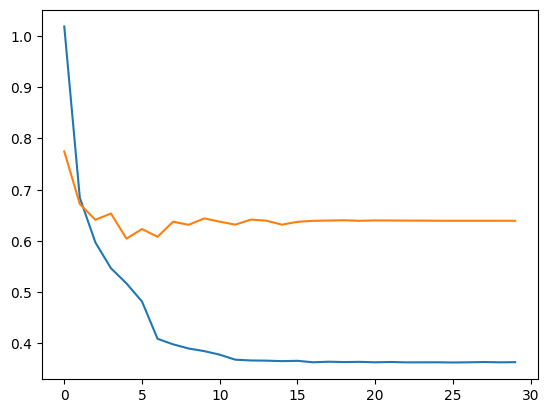

In [ ]:
plt.plot(hist_20.history['loss'])
plt.plot(hist_20.history['val_loss'])

In [ ]:
print(hist_20.history.keys())


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


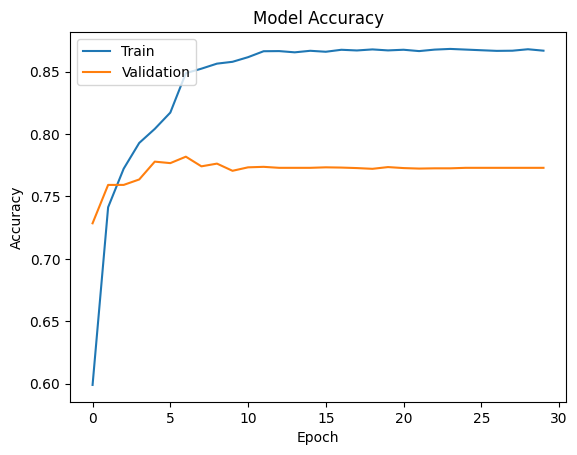

In [ ]:
plt.plot(hist_20.history["categorical_accuracy"])
plt.plot(hist_20.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

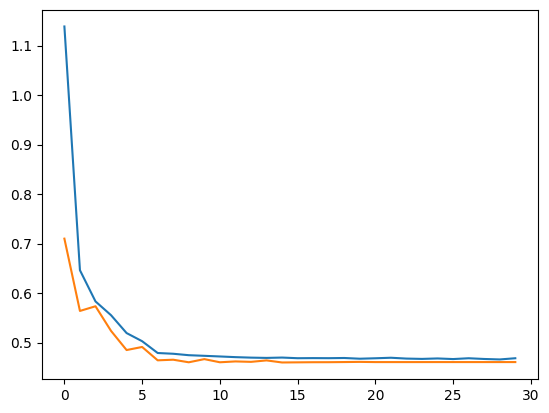

In [ ]:
plt.plot(hist_19.history["loss"])
plt.plot(hist_19.history["val_loss"])

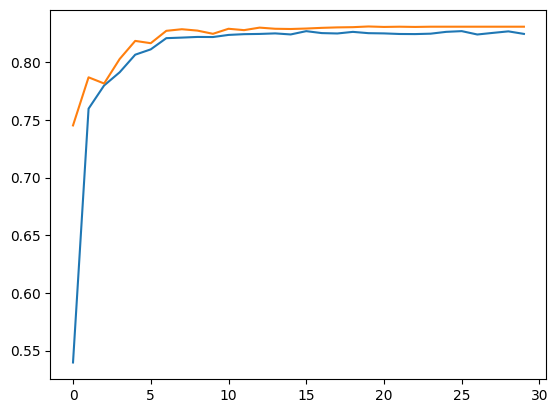

In [ ]:
plt.plot(hist_19.history["acc"])
plt.plot(hist_19.history["val_acc"])

# 7. So sánh với các mô hình phân loại khác

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
# logging for visual comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
X_train_squeezed = np.squeeze(X_train)
X_test_squeezed = np.squeeze(X_test)
for clf in classifiers:
    clf.fit(X_train_squeezed, y_train)
    name = clf.__class__.__name__
    if VBS:
        print("-"*27)
        print(name)
        print('----------Results----------')
    train_predictions = clf.predict(X_test_squeezed)
    acc = accuracy_score(y_test, train_predictions)
    if VBS:
        print("Accuracy: {:.2%}".format(acc))
    train_predictions = clf.predict_proba(X_test_squeezed)
    ll = log_loss(y_test, train_predictions)
    if VBS:
        print("Log Loss: {:.2f}".format(ll))
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)


---------------------------
KNeighborsClassifier
----------Results----------
Accuracy: 16.31%
Log Loss: 23.49
---------------------------
DecisionTreeClassifier
----------Results----------
Accuracy: 38.02%
Log Loss: 22.34
---------------------------
RandomForestClassifier
----------Results----------
Accuracy: 55.28%
Log Loss: 1.16
---------------------------
XGBClassifier
----------Results----------
Accuracy: 66.32%
Log Loss: 0.86
---------------------------
AdaBoostClassifier
----------Results----------
Accuracy: 43.70%
Log Loss: 1.59
---------------------------
GaussianNB
----------Results----------
Accuracy: 29.42%
Log Loss: 23.60
---------------------------
LinearDiscriminantAnalysis
----------Results----------
Accuracy: 42.86%
Log Loss: 1.61
---------------------------
QuadraticDiscriminantAnalysis
----------Results----------
Accuracy: 58.51%
Log Loss: 14.64


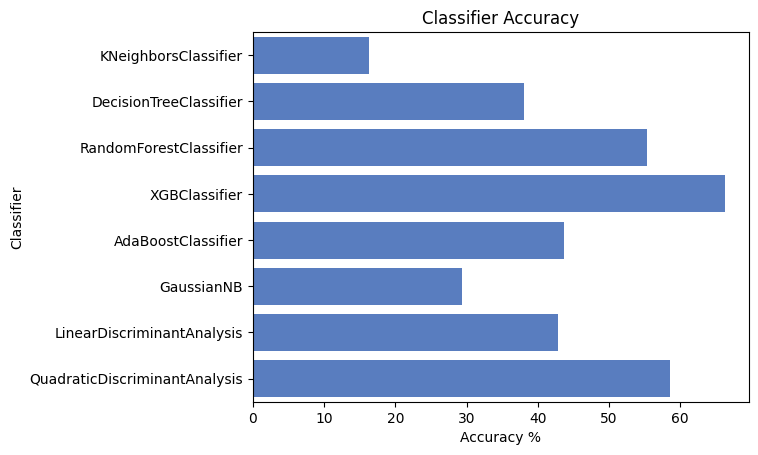

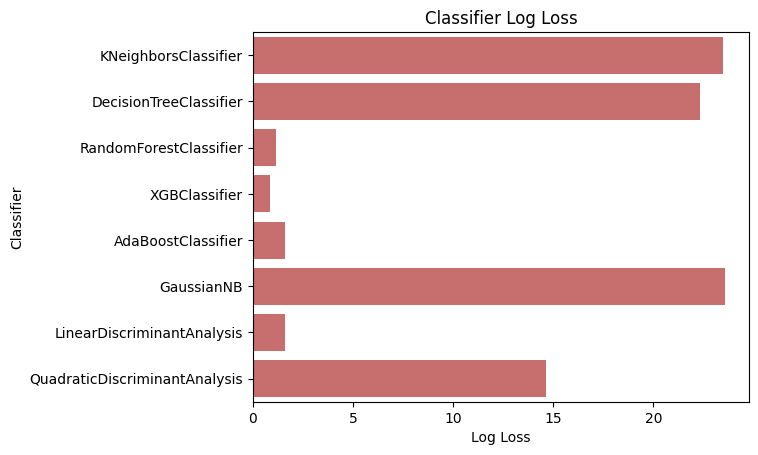

In [ ]:
pdf_report2 = PdfPages('Classifiers_Results.pdf')
fig1 = plt.figure()
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
pdf_report2.savefig(fig1, bbox_inches='tight')
plt.show()

fig2 = plt.figure()
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="r")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
pdf_report2.savefig(fig2, bbox_inches='tight')
plt.show()
pdf_report2.close()